In [7]:
import pandas as pd
import numpy as np
import warnings
from dataclasses import dataclass
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from datetime import datetime
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pickle
from collections import defaultdict



In [ ]:
df = pd.read_csv('shot_logs.csv')

print("Dataset Shape:", df.shape)
print("\nColumns available:")
for col in df.columns:
    print(f"- {col}")

target_players = ['lebron james', 'stephen curry', 'james harden']
player_shots = df['player_name'].value_counts()
print("\nShot attempts for our players of interest:")
for player in target_players:
    if player in player_shots:
        print(f"{player}: {player_shots[player]} shots")
        
print("\nFirst few rows of the dataset:")
display(df.head())

missing_values = df.isnull().sum()
if missing_values.any():
    print("\nMissing values in the dataset:")
    print(missing_values[missing_values > 0])

Dataset Shape: (128069, 21)

Columns available:
- GAME_ID
- MATCHUP
- LOCATION
- W
- FINAL_MARGIN
- SHOT_NUMBER
- PERIOD
- GAME_CLOCK
- SHOT_CLOCK
- DRIBBLES
- TOUCH_TIME
- SHOT_DIST
- PTS_TYPE
- SHOT_RESULT
- CLOSEST_DEFENDER
- CLOSEST_DEFENDER_PLAYER_ID
- CLOSE_DEF_DIST
- FGM
- PTS
- player_name
- player_id

Shot attempts for our players of interest:
lebron james: 978 shots
stephen curry: 968 shots
james harden: 1054 shots

First few rows of the dataset:


,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148



Missing values in the dataset:
SHOT_CLOCK    5567
dtype: int64


In [ ]:
def enhance_shot_logs(df):
    df = df.copy()
    print("Processing shot data...")

    df = df.sort_values(['player_name', 'PERIOD', 'GAME_CLOCK'], ascending=[True, True, False])

    df['cum_fg_made'] = df.groupby(['player_name', 'GAME_ID'])['FGM'].cumsum().shift(1).fillna(0)
    df['cum_fg_attempts'] = df.groupby(['player_name', 'GAME_ID']).cumcount()

    df['player_fg_pct'] = np.where(
        df['cum_fg_attempts'] > 0,
        df['cum_fg_made'] / df['cum_fg_attempts'],
        0
    )

    def clock_to_sec(clock_str):
        try:
            mins, secs = map(float, clock_str.split(':'))
            return mins * 60 + secs
        except:
            return np.nan

    df['GAME_CLOCK_SEC'] = df['GAME_CLOCK'].apply(clock_to_sec)
    if df['SHOT_CLOCK'].isna().any():
        print("Found NaN in SHOT_CLOCK, imputing with 14 seconds...")
        df['SHOT_CLOCK'] = pd.to_numeric(df['SHOT_CLOCK'], errors='coerce')  
        df['SHOT_CLOCK'] = df['SHOT_CLOCK'].fillna(14.0)  

    def get_game_stage(period):
        if period in [1, 2]:
            return 'early'
        elif period == 3:
            return 'mid'
        else:
            return 'late'
    df['game_stage'] = df['PERIOD'].apply(get_game_stage)

    conditions = [
        (df['PERIOD'].isin([1, 2])) & (df['GAME_CLOCK_SEC'] >= 540),
        (df['PERIOD'].isin([1, 2])) & (df['GAME_CLOCK_SEC'] < 540),
        (df['PERIOD'] == 3) & (df['GAME_CLOCK_SEC'] >= 540),
        (df['PERIOD'] == 3) & (df['GAME_CLOCK_SEC'] < 540),
        (df['PERIOD'] >= 4) & (df['GAME_CLOCK_SEC'] >= 180),
        (df['PERIOD'] >= 4) & (df['GAME_CLOCK_SEC'] < 180)
    ]
    choices = ['very_early', 'early', 'mid_start', 'mid_end', 'late', 'clutch']
    df['detailed_game_stage'] = np.select(conditions, choices, default='unknown')

    df['shot_zone_distance'] = pd.cut(
        df['SHOT_DIST'],
        bins=[-np.inf, 4, 14, 22, np.inf],
        labels=['restricted_area', 'mid_range', 'long_range', 'deep_three']
    )

    print("Data enhancement complete.")
    return df

df = pd.read_csv('shot_logs.csv')

players_of_interest = ['lebron james', 'stephen curry', 'james harden']
df_filtered = df[df['player_name'].isin(players_of_interest)]

enhanced_df = enhance_shot_logs(df_filtered)

def display_enhanced_stats(enhanced_df):
    """Display sample statistics from the enhanced dataset"""
    for player in players_of_interest:
        print(f"\n{'='*50}")
        print(f"Stats for {player}:")
        player_data = enhanced_df[enhanced_df['player_name'] == player]
        
        print(f"\nTotal shots: {len(player_data)}")
        if len(player_data) > 0:
            print(f"Overall FG%: {player_data['FGM'].mean():.3f}")
            
            print("\nFG% by game stage:")
            stage_stats = player_data.groupby('game_stage')['FGM'].agg(['mean', 'count'])
            print(stage_stats)
            
            print("\nFG% by detailed game stage:")
            detailed_stats = player_data.groupby('detailed_game_stage')['FGM'].agg(['mean', 'count'])
            print(detailed_stats)
            
            print("\nFG% by shot zone:")
            zone_stats = player_data.groupby('shot_zone_distance')['FGM'].agg(['mean', 'count'])
            print(zone_stats)
            
            print(f"\nAverage defender distance: {player_data['CLOSE_DEF_DIST'].mean():.2f} feet")
            print(f"Average dribbles per shot: {player_data['DRIBBLES'].mean():.2f}")
            print(f"Average FG% at time of shot: {player_data['player_fg_pct'].mean():.3f}")
        else:
            print("No shots found for this player")


display_enhanced_stats(enhanced_df)

print("\nSample of enhanced data for verification:")
sample_cols = ['player_name', 'PERIOD', 'FGM', 'player_fg_pct', 
               'game_stage', 'detailed_game_stage', 'shot_zone_distance']
print(enhanced_df[sample_cols].head(10))

print("\nTotal shots by player:")
print(enhanced_df['player_name'].value_counts())


Processing shot data...
Found NaN in SHOT_CLOCK, imputing with 14 seconds...
Data enhancement complete.

Stats for lebron james:

Total shots: 978
Overall FG%: 0.489

FG% by game stage:
                mean  count
game_stage                 
early       0.484791    526
late        0.485437    206
mid         0.500000    246

FG% by detailed game stage:
                         mean  count
detailed_game_stage                 
clutch               0.372549     51
early                0.466667    405
late                 0.522581    155
mid_end              0.516129    186
mid_start            0.450000     60
very_early           0.545455    121

FG% by shot zone:
                        mean  count
shot_zone_distance                 
restricted_area     0.745856    181
mid_range           0.510903    321
long_range          0.433155    187
deep_three          0.339100    289

Average defender distance: 4.19 feet
Average dribbles per shot: 4.67
Average FG% at time of shot: 0.623

Stats fo

In [ ]:
@dataclass
class ShotAlternative:
    shot_distance: float
    defender_distance: float
    shot_clock: float
    game_clock: float
    period: int
    dribbles: int
    shot_zone: str
    game_stage: str
    player_fg_pct: float
    is_original: bool = False
    
    def to_dict(self) -> Dict:
        return {
            'SHOT_DIST': self.shot_distance,
            'CLOSE_DEF_DIST': self.defender_distance,
            'SHOT_CLOCK': self.shot_clock,
            'GAME_CLOCK': self.game_clock,
            'PERIOD': self.period,
            'DRIBBLES': self.dribbles,
            'shot_zone': self.shot_zone,
            'game_stage': self.game_stage,
            'player_fg_pct': self.player_fg_pct,
            'is_original': self.is_original,
            'IS_CHOSEN': 1 if self.is_original else 0
        }
    
    def distance_to(self, other: 'ShotAlternative') -> float:
        return np.sqrt(
            ((self.shot_distance - other.shot_distance) / 35.0) ** 2 +
            ((self.defender_distance - other.defender_distance) / 10.0) ** 2 +
            ((self.shot_clock - other.shot_clock) / 24.0) ** 2 +
            ((self.player_fg_pct - other.player_fg_pct) / 1.0) ** 2
        )

class ShotAlternativeGenerator:
    def __init__(self, shot_data: pd.DataFrame):
        self.shot_data = shot_data
        self.zone_stats = self._calculate_zone_stats()
        self.defender_stats = self._calculate_defender_stats()
        self.generation_stats = {
            'total_alternatives': 0,
            'zone_changes': {},
            'avg_distance_to_original': [],
            'rejected_alternatives': 0
        }
    
    def _calculate_zone_stats(self) -> Dict:
        stats = {}
        for zone in self.shot_data['shot_zone_distance'].unique():
            zone_data = self.shot_data[self.shot_data['shot_zone_distance'] == zone]
            stats[zone] = {
                'mean_dist': zone_data['SHOT_DIST'].mean(),
                'std_dist': zone_data['SHOT_DIST'].std(),
                'freq': len(zone_data) / len(self.shot_data)
            }
        return stats
    
    def _calculate_defender_stats(self) -> Dict:
        stats = {}
        for zone in self.shot_data['shot_zone_distance'].unique():
            zone_data = self.shot_data[self.shot_data['shot_zone_distance'] == zone]
            stats[zone] = {
                'mean_def_dist': zone_data['CLOSE_DEF_DIST'].mean(),
                'std_def_dist': zone_data['CLOSE_DEF_DIST'].std()
            }
        return stats
    
    def _generate_alternative_distance(self, 
                                    original_zone: str,
                                    allow_zone_change: bool = True) -> Tuple[float, str]:
        if allow_zone_change and np.random.random() < 0.3: 
            new_zone = np.random.choice(
                list(self.zone_stats.keys()),
                p=[stats['freq'] for stats in self.zone_stats.values()]
            )
        else:
            new_zone = original_zone
            
        zone_mean = self.zone_stats[new_zone]['mean_dist']
        zone_std = self.zone_stats[new_zone]['std_dist']
        
        new_distance = np.clip(
            np.random.normal(zone_mean, zone_std),
            0,  
            35  
        )
        
        return new_distance, new_zone
    
    def _generate_alternative_defender_distance(self, 
                                             shot_zone: str,
                                             original_def_dist: float) -> float:
        zone_stats = self.defender_stats[shot_zone]
        
        if np.random.random() < 0.7: 
            base = original_def_dist
            std = zone_stats['std_def_dist'] * 0.5
        else:
            base = zone_stats['mean_def_dist']
            std = zone_stats['std_def_dist']
            
        return np.clip(
            np.random.normal(base, std),
            0,  
            10  
        )
    
    def _adjust_shot_clock(self, 
                          original_clock: float,
                          game_stage: str) -> float:
        if game_stage == 'clutch':
            variation = np.random.normal(0, 1) 
        else:
            variation = np.random.normal(0, 2) 
            
        return np.clip(
            original_clock + variation,
            0,  
            24  
        )
    
    def generate_alternatives(self,
                            original_shot: pd.Series,
                            n_alternatives: int = 3,
                            visualize: bool = False,
                            min_difference_threshold: float = 0.2
                            ) -> List[ShotAlternative]:
        alternatives = []
        
        original = ShotAlternative(
            shot_distance=original_shot['SHOT_DIST'],
            defender_distance=original_shot['CLOSE_DEF_DIST'],
            shot_clock=float(original_shot['SHOT_CLOCK']),
            game_clock=float(original_shot['GAME_CLOCK'].split(':')[0]) * 60 + 
                      float(original_shot['GAME_CLOCK'].split(':')[1]),
            period=original_shot['PERIOD'],
            dribbles=original_shot['DRIBBLES'],
            shot_zone=original_shot['shot_zone_distance'],
            game_stage=original_shot['detailed_game_stage'],
            player_fg_pct=original_shot['player_fg_pct'],
            is_original=True
        )
        alternatives.append(original)
        
        max_attempts = n_alternatives * 3
        attempts = 0
        
        while len(alternatives) < n_alternatives + 1 and attempts < max_attempts:
            attempts += 1
            
            new_dist, new_zone = self._generate_alternative_distance(
                original_shot['shot_zone_distance']
            )
            
            new_def_dist = self._generate_alternative_defender_distance(
                new_zone,
                original_shot['CLOSE_DEF_DIST']
            )
            
            new_shot_clock = self._adjust_shot_clock(
                float(original_shot['SHOT_CLOCK']),
                original_shot['detailed_game_stage']
            )
            new_shot_clock = min(new_shot_clock, original.game_clock)

            new_fg_pct = np.clip(
                original_shot['player_fg_pct'] + np.random.normal(0, 0.02),
                0,  
                1   
            )
            
            alternative = ShotAlternative(
                shot_distance=new_dist,
                defender_distance=new_def_dist,
                shot_clock=new_shot_clock,
                game_clock=original.game_clock,
                period=original.period,
                dribbles=max(0, int(original_shot['DRIBBLES'] + np.random.normal(0, 1))),
                shot_zone=new_zone,
                game_stage=original.game_stage,
                player_fg_pct=new_fg_pct,
                is_original=False
            )
            
            is_different = True
            for existing_alt in alternatives:
                if alternative.distance_to(existing_alt) < min_difference_threshold:
                    is_different = False
                    self.generation_stats['rejected_alternatives'] += 1
                    break
            
            if is_different:
                alternatives.append(alternative)
                self.generation_stats['total_alternatives'] += 1
                self.generation_stats['avg_distance_to_original'].append(
                    alternative.distance_to(original)
                )
                self.generation_stats['zone_changes'][new_zone] = \
                    self.generation_stats['zone_changes'].get(new_zone, 0) + 1
        
        if visualize:
            self._visualize_alternatives(alternatives)
        
        return alternatives
    
    def generate_batch_alternatives(self,
                                 shots_df: pd.DataFrame,
                                 n_alternatives: int = 3,
                                 progress_bar: bool = True) -> pd.DataFrame:
        all_shots = []
        group_sizes = []
        iterator = tqdm(shots_df.iterrows()) if progress_bar else shots_df.iterrows()
        
        for idx, shot in iterator:
            alternatives = self.generate_alternatives(shot, n_alternatives)
            all_shots.extend([alt.to_dict() for alt in alternatives])
            group_sizes.append(len(alternatives))
        
        result_df = pd.DataFrame(all_shots)
        
        group_ids = []
        for idx, size in enumerate(group_sizes):
            group_ids.extend([idx] * size)
        
        result_df['group_id'] = group_ids
        
        return result_df
    
    def _visualize_alternatives(self, alternatives: List[ShotAlternative]):
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        for alt in alternatives:
            color = 'red' if alt.is_original else 'blue'
            marker = '*' if alt.is_original else 'o'
            size = 200 if alt.is_original else 100
            plt.scatter(alt.shot_distance, alt.defender_distance, 
                       c=color, marker=marker, s=size, alpha=0.6)
        
        plt.xlabel('Shot Distance (feet)')
        plt.ylabel('Defender Distance (feet)')
        plt.title('Shot vs Defender Distance')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 2)
        for alt in alternatives:
            color = 'red' if alt.is_original else 'blue'
            marker = '*' if alt.is_original else 'o'
            size = 200 if alt.is_original else 100
            plt.scatter(alt.shot_distance, alt.shot_clock,
                       c=color, marker=marker, s=size, alpha=0.6)
        
        plt.xlabel('Shot Distance (feet)')
        plt.ylabel('Shot Clock (seconds)')
        plt.title('Shot Distance vs Shot Clock')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 3)
        for alt in alternatives:
            color = 'red' if alt.is_original else 'blue'
            marker = '*' if alt.is_original else 'o'
            size = 200 if alt.is_original else 100
            plt.scatter(alt.shot_distance, alt.player_fg_pct,
                       c=color, marker=marker, s=size, alpha=0.6)
        
        plt.xlabel('Shot Distance (feet)')
        plt.ylabel('Player FG%')
        plt.title('Shot Distance vs FG%')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def print_generation_stats(self):
        print("\nAlternative Generation Statistics:")
        print(f"Total alternatives generated: {self.generation_stats['total_alternatives']}")
        print(f"Rejected alternatives: {self.generation_stats['rejected_alternatives']}")
        
        if self.generation_stats['avg_distance_to_original']:
            avg_distance = np.mean(self.generation_stats['avg_distance_to_original'])
            print(f"\nAverage distance to original shots: {avg_distance:.3f}")
        
        print("\nZone distribution of alternatives:")
        total_zones = sum(self.generation_stats['zone_changes'].values())
        if total_zones > 0:
            for zone, count in self.generation_stats['zone_changes'].items():
                percentage = (count / total_zones) * 100
                print(f"{zone}: {percentage:.1f}% ({count} shots)")



Analysis started by cnguyen at 2025-06-05 01:26:43 UTC


Generating alternatives for 5 sample shots...


5it [00:00, 1285.97it/s]


Alternative Generation Statistics:
Total alternatives generated: 15
Rejected alternatives: 5

Average distance to original shots: 0.399

Zone distribution of alternatives:
deep_three: 46.7% (7 shots)
long_range: 13.3% (2 shots)
restricted_area: 13.3% (2 shots)
mid_range: 26.7% (4 shots)

Group sizes:
group_id
0    4
1    4
2    4
3    4
4    4
dtype: int64

Sample of generated alternatives:
    SHOT_DIST  CLOSE_DEF_DIST  SHOT_CLOCK  GAME_CLOCK  PERIOD  DRIBBLES  \
0        18.7             4.9        12.0       598.0       1         7   
4        11.3             4.2         3.9       584.0       1         2   
8        24.5             3.5        21.0       584.0       1         0   
12       16.0             4.9        12.1       572.0       1         4   
16       24.8             3.4         8.6       568.0       1         0   

     shot_zone  game_stage  player_fg_pct  is_original  IS_CHOSEN  group_id  
0   long_range  very_early            0.0         True          1         0 

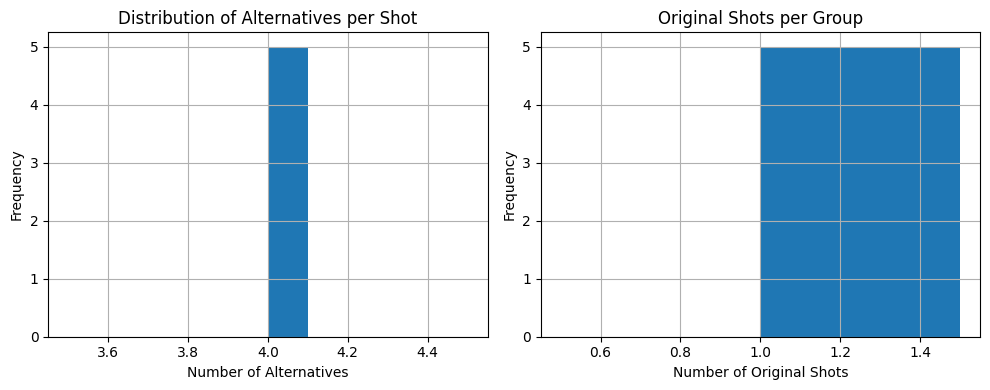

Analysis completed at 2025-06-05 01:26:50 UTC


In [ ]:
def run_alternative_generation_example(enhanced_df: pd.DataFrame):
    generator = ShotAlternativeGenerator(enhanced_df)
    
    sample_shots = enhanced_df.head(5)
    print("Generating alternatives for 5 sample shots...")
    batch_results = generator.generate_batch_alternatives(
        sample_shots,
        n_alternatives=3,
        progress_bar=True
    )
    
    generator.print_generation_stats()
    
    print("\nGroup sizes:")
    print(batch_results.groupby('group_id').size())
    
    print("\nSample of generated alternatives:")
    print(batch_results.groupby('group_id').head(1))
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    batch_results.groupby('group_id').size().hist(bins=10)
    plt.title('Distribution of Alternatives per Shot')
    plt.xlabel('Number of Alternatives')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    batch_results.groupby('group_id')['is_original'].sum().hist(bins=2)
    plt.title('Original Shots per Group')
    plt.xlabel('Number of Original Shots')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    return batch_results

if 'enhanced_df' in globals():
    batch_results = run_alternative_generation_example(enhanced_df)
else:
    print("Please run your data preparation code first to create enhanced_df")


Initial shape of enhanced dataset: (3000, 28)

Generating alternatives for lebron james
Available shots: 978
Generating 3 alternatives for 800 shots...


800it [00:00, 1417.24it/s]



Alternative Generation Statistics:
Total alternatives generated: 2150
Rejected alternatives: 3149

Average distance to original shots: 0.470

Zone distribution of alternatives:
mid_range: 28.9% (622 shots)
deep_three: 35.3% (760 shots)
long_range: 15.2% (327 shots)
restricted_area: 20.5% (441 shots)

Generating alternatives for stephen curry
Available shots: 968
Generating 3 alternatives for 800 shots...


800it [00:00, 1381.06it/s]



Alternative Generation Statistics:
Total alternatives generated: 2151
Rejected alternatives: 3108

Average distance to original shots: 0.478

Zone distribution of alternatives:
deep_three: 42.3% (909 shots)
mid_range: 25.6% (550 shots)
long_range: 14.8% (319 shots)
restricted_area: 17.3% (373 shots)

Generating alternatives for james harden
Available shots: 1054
Generating 3 alternatives for 800 shots...


800it [00:00, 1249.29it/s]



Alternative Generation Statistics:
Total alternatives generated: 2149
Rejected alternatives: 3155

Average distance to original shots: 0.452

Zone distribution of alternatives:
long_range: 15.2% (327 shots)
deep_three: 38.4% (826 shots)
mid_range: 26.2% (563 shots)
restricted_area: 20.1% (433 shots)

Summary of generated alternatives:

Statistics for lebron james:
Original shots: 800
Alternative shots: 2150

Original Shot Averages:
Distance: 14.12 feet
Defender Distance: 4.24 feet
Shot Clock: 11.76 seconds

Alternative Shot Averages:
Distance: 14.36 feet
Defender Distance: 4.27 feet
Shot Clock: 11.47 seconds

Statistics for stephen curry:
Original shots: 800
Alternative shots: 2151

Original Shot Averages:
Distance: 17.44 feet
Defender Distance: 4.55 feet
Shot Clock: 14.95 seconds

Alternative Shot Averages:
Distance: 15.71 feet
Defender Distance: 4.41 feet
Shot Clock: 14.79 seconds

Statistics for james harden:
Original shots: 800
Alternative shots: 2149

Original Shot Averages:
Dist

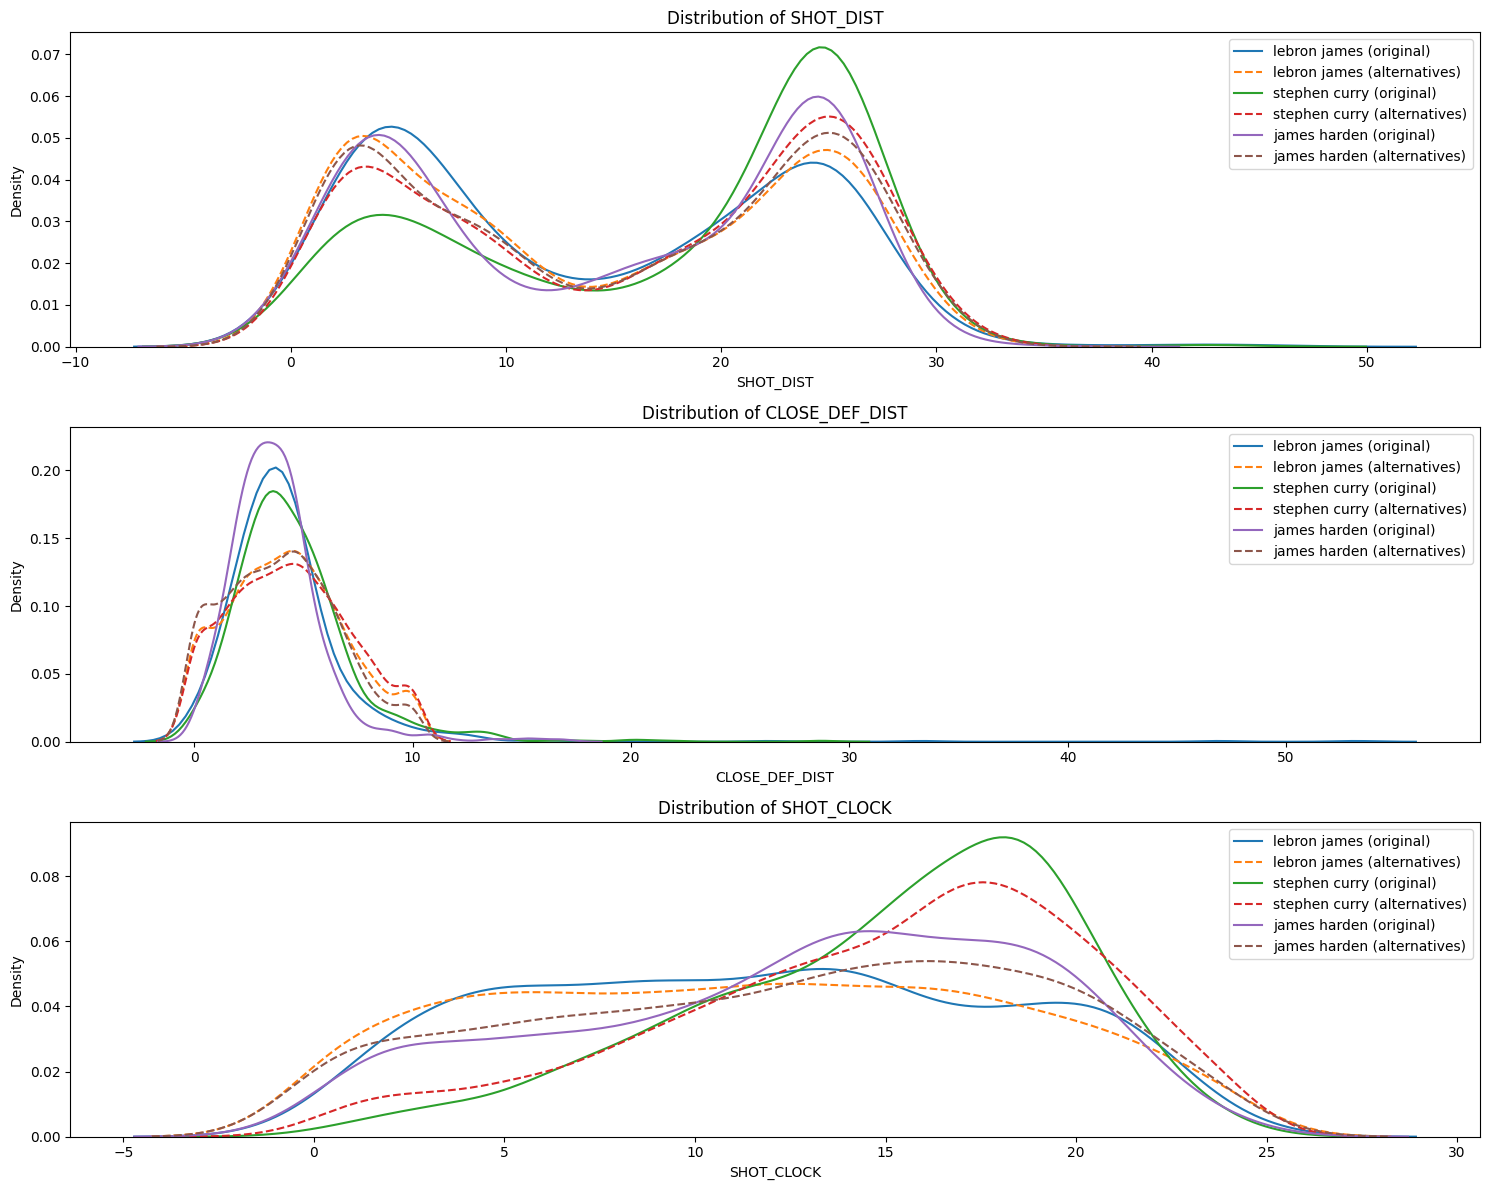


Results saved to 'shot_alternatives.csv'

Sample of generated alternatives:


,SHOT_DIST,CLOSE_DEF_DIST,SHOT_CLOCK,GAME_CLOCK,PERIOD,DRIBBLES,shot_zone,game_stage,player_fg_pct,is_original,IS_CHOSEN,group_id,player_name
0,5.7,0.0,14.0,705.0,1,0,mid_range,very_early,1.000000,True,1,0,lebron james
4,3.5,1.9,18.2,551.0,3,3,restricted_area,mid_start,0.416667,True,1,1,lebron james
8,5.8,2.5,22.5,110.0,1,1,mid_range,early,1.000000,True,1,2,lebron james
10,6.3,2.3,16.6,694.0,4,8,mid_range,late,0.937500,True,1,3,lebron james
14,18.9,5.5,14.4,448.0,1,11,long_range,early,0.500000,True,1,4,lebron james


In [ ]:
print("Initial shape of enhanced dataset:", enhanced_df.shape)

def generate_player_alternatives(enhanced_df, player_name, n_shots=800, n_alternatives=3):
    player_data = enhanced_df[enhanced_df['player_name'].str.lower() == player_name.lower()]
    
    print(f"\nGenerating alternatives for {player_name}")
    print(f"Available shots: {len(player_data)}")
    
    player_data = player_data.sample(n=n_shots, random_state=42)
    
    generator = ShotAlternativeGenerator(enhanced_df)
    
    print(f"Generating {n_alternatives} alternatives for {n_shots} shots...")
    batch_results = generator.generate_batch_alternatives(
        player_data,
        n_alternatives=n_alternatives,
        progress_bar=True
    )
    
    generator.print_generation_stats()
    
    batch_results['player_name'] = player_name
    
    return batch_results

all_results = []
for player in players_of_interest:  
    player_results = generate_player_alternatives(
        enhanced_df,
        player_name=player,
        n_shots=800,  
        n_alternatives=3
    )
    all_results.append(player_results)

combined_results = pd.concat(all_results, ignore_index=True)

print("\nSummary of generated alternatives:")
for player in players_of_interest:
    player_data = combined_results[combined_results['player_name'] == player]
    orig_shots = player_data[player_data['is_original']]
    alt_shots = player_data[~player_data['is_original']]
    
    print(f"\n{'='*50}")
    print(f"Statistics for {player}:")
    print(f"Original shots: {len(orig_shots)}")
    print(f"Alternative shots: {len(alt_shots)}")
    
    print("\nOriginal Shot Averages:")
    print(f"Distance: {orig_shots['SHOT_DIST'].mean():.2f} feet")
    print(f"Defender Distance: {orig_shots['CLOSE_DEF_DIST'].mean():.2f} feet")
    print(f"Shot Clock: {orig_shots['SHOT_CLOCK'].mean():.2f} seconds")
    
    print("\nAlternative Shot Averages:")
    print(f"Distance: {alt_shots['SHOT_DIST'].mean():.2f} feet")
    print(f"Defender Distance: {alt_shots['CLOSE_DEF_DIST'].mean():.2f} feet")
    print(f"Shot Clock: {alt_shots['SHOT_CLOCK'].mean():.2f} seconds")

plt.figure(figsize=(15, 12))

for idx, feature in enumerate(['SHOT_DIST', 'CLOSE_DEF_DIST', 'SHOT_CLOCK']):
    plt.subplot(3, 1, idx+1)
    for player in players_of_interest:
        player_data = combined_results[combined_results['player_name'] == player]
        
        sns.kdeplot(data=player_data[player_data['is_original']][feature], 
                   label=f'{player} (original)',
                   linestyle='-')
        
        sns.kdeplot(data=player_data[~player_data['is_original']][feature],
                   label=f'{player} (alternatives)',
                   linestyle='--')
    
    plt.title(f'Distribution of {feature}')
    plt.legend()

plt.tight_layout()
plt.show()

combined_results.to_csv('shot_alternatives.csv', index=False)
print("\nResults saved to 'shot_alternatives.csv'")

print("\nSample of generated alternatives:")
display(combined_results.groupby(['player_name', 'group_id']).head(1).head())

In [ ]:
class KKTCostFunction(nn.Module):
    def __init__(self, input_dim=12, n_constraints=3):
        super(KKTCostFunction, self).__init__()
        
        hidden_dims = [64, 32, 16]
        layers = []
        prev_dim = input_dim
        
        for i, hidden_dim in enumerate(hidden_dims):
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.LeakyReLU(0.2),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(0.3 if i == 0 else 0.2)
            ])
            prev_dim = hidden_dim
        
        final_layer = nn.Linear(prev_dim, 1)
        nn.init.xavier_uniform_(final_layer.weight, gain=0.01)
        layers.append(final_layer)
        
        self.network = nn.Sequential(*layers)
        self.dual_vars = nn.Parameter(torch.zeros(n_constraints))
        self.dual_activation = nn.Softplus()
    
    def forward(self, x):
        if not x.requires_grad:
            x = x.detach().clone().requires_grad_(True)
        return self.network(x)
    
    def get_constraints(self, features):
        shot_clock = features[:, 2]
        def_dist = features[:, 1]
        shot_dist = features[:, 0]
        
        constraints = {
            'shot_clock': -shot_clock,
            'def_dist': def_dist - 10.0,
            'shot_dist': shot_dist - 35.0
        }
        
        return constraints
    
    def compute_lagrangian(self, features, output):
        cost = output.mean()
        
        constraints = self.get_constraints(features)
        dual_vars = self.dual_activation(self.dual_vars)
        
        lagrangian = cost
        for i, (_, constraint) in enumerate(constraints.items()):
            lagrangian = lagrangian + dual_vars[i] * constraint.mean()
        
        return lagrangian
    
    def get_kkt_violations(self, features, output):
        features = features.detach().clone().requires_grad_(True)
        
        with torch.enable_grad():
            output = self.forward(features)
            lagrangian = self.compute_lagrangian(features, output)
            
            grad_L = torch.autograd.grad(
                lagrangian,
                features,
                create_graph=True,
                retain_graph=True,
                allow_unused=True
            )[0]
            
            if grad_L is None:
                grad_L = torch.zeros_like(features)
            
            constraints = self.get_constraints(features)
            dual_vars = self.dual_activation(self.dual_vars)
            
            violations = {
                'stationarity': grad_L.norm(dim=1).mean(),
                'comp_slackness': sum(
                    dual_vars[i] * constraint.mean()
                    for i, (_, constraint) in enumerate(constraints.items())
                ),
                'dual_feasibility': torch.zeros(1, requires_grad=True),
                'primal_feasibility': sum(
                    torch.relu(constraint.mean())
                    for constraint in constraints.values()
                )
            }
        
        return violations

    def compute_losses(self, features, labels):
        features = features.detach().clone().requires_grad_(True)
        
        with torch.enable_grad():
            outputs = self.forward(features)
            
            bce_loss = nn.BCEWithLogitsLoss(reduction='mean')(outputs.squeeze(), labels)
            
            violations = self.get_kkt_violations(features, outputs)
            
            return {
                'bce_loss': bce_loss,
                **violations
            }



In [ ]:
class ShotDataset(Dataset):
    def __init__(self, data: pd.DataFrame):
        self.data = data.copy()
        
        numerical_features = [
            'SHOT_DIST', 'CLOSE_DEF_DIST', 'SHOT_CLOCK', 'DRIBBLES',
            'player_fg_pct'
        ]
        
        for col in numerical_features:
            self.data[col] = pd.to_numeric(self.data[col], errors='coerce')
        
        self.data = self.data.dropna(subset=numerical_features)
        
        self.feature_means = {}
        self.feature_stds = {}
        
        for feature in numerical_features:
            self.feature_means[feature] = self.data[feature].mean()
            self.feature_stds[feature] = self.data[feature].std() or 1.0
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        feature_values = [
            (row['SHOT_DIST'] - self.feature_means['SHOT_DIST']) / self.feature_stds['SHOT_DIST'],
            (row['CLOSE_DEF_DIST'] - self.feature_means['CLOSE_DEF_DIST']) / self.feature_stds['CLOSE_DEF_DIST'],
            (row['SHOT_CLOCK'] - self.feature_means['SHOT_CLOCK']) / self.feature_stds['SHOT_CLOCK'],
            (row['DRIBBLES'] - self.feature_means['DRIBBLES']) / self.feature_stds['DRIBBLES'],
            (row['player_fg_pct'] - self.feature_means['player_fg_pct']) / self.feature_stds['player_fg_pct'],
            
            1.0 if row['shot_zone'] == 'restricted_area' else 0.0,
            1.0 if row['shot_zone'] == 'mid_range' else 0.0,
            1.0 if row['shot_zone'] == 'long_range' else 0.0,
            1.0 if row['shot_zone'] == 'deep_three' else 0.0,
            
            1.0 if row['game_stage'] == 'early' else 0.0,
            1.0 if row['game_stage'] == 'mid' else 0.0,
            1.0 if row['game_stage'] == 'late' else 0.0
        ]
        
        features = torch.tensor(feature_values, dtype=torch.float32, requires_grad=True)
        
        label = torch.tensor(row['IS_CHOSEN'], dtype=torch.float32)
        group = torch.tensor(row['group_id'], dtype=torch.long)
        
        return features, label, group


In [ ]:
class KKTOptimizer:
    def __init__(self, learning_rate=0.001, n_epochs=200, batch_size=32, 
                 early_stopping_patience=20, kkt_weight=0.1):
        self.cost_function = KKTCostFunction()
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.early_stopping_patience = early_stopping_patience
        self.kkt_weight = kkt_weight
        
        self.optimizer = optim.AdamW(
            self.cost_function.parameters(),
            lr=learning_rate,
            weight_decay=0.01
        )
    
    def train_step(self, features, labels):
        """Single training step with proper gradient handling"""
        self.optimizer.zero_grad()
        
        features = features.detach().clone().requires_grad_(True)
        
        with torch.enable_grad():
            losses = self.cost_function.compute_losses(features, labels)
            
            total_loss = losses['bce_loss'] + self.kkt_weight * (
                losses['stationarity'] +
                losses['comp_slackness'] +
                losses['primal_feasibility']
            )
            
            # Debug info
            #print("Debug - Loss components:")
            #print(f"BCE Loss: {losses['bce_loss'].item()}")
            #print(f"Stationarity: {losses['stationarity'].item()}")
            #print(f"Comp Slackness: {losses['comp_slackness'].item()}")
            #print(f"Primal Feasibility: {losses['primal_feasibility'].item()}")
            #print(f"Total Loss requires grad: {total_loss.requires_grad}")
            
            total_loss.backward()
            
            self.optimizer.step()
            
            return losses
    def train(self, dataset: ShotDataset) -> Dict:
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(
            dataset, [train_size, val_size],
            generator=torch.Generator().manual_seed(42)
        )
        
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )
        
        history = defaultdict(list)
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(self.n_epochs):
            self.cost_function.train()
            train_losses = defaultdict(float)
            
            # Training loop
            for features, labels, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
                losses = self.train_step(features, labels)
                for k, v in losses.items():
                    train_losses[k] += v.item()
            
            # Validation loop
            self.cost_function.eval()
            val_losses = defaultdict(float)
            
            with torch.no_grad():
                for features, labels, _ in val_loader:
                    features.requires_grad_(True)
                    losses = self.cost_function.compute_losses(features, labels)
                    for k, v in losses.items():
                        val_losses[k] += v.item()
            
            # Log metrics
            for k in train_losses.keys():
                history[f'train_{k}'].append(train_losses[k] / len(train_loader))
                history[f'val_{k}'].append(val_losses[k] / len(val_loader))
            
            val_loss = val_losses['bce_loss'] / len(val_loader)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= self.early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        return history

    def get_feature_importances(self, dataset: ShotDataset) -> Dict[str, float]:
        self.cost_function.eval()
        feature_names = [
            'Shot Distance', 'Defender Distance', 'Shot Clock', 'Dribbles',
            'Player FG%', 'Restricted Area', 'Mid Range', 'Long Range', 
            'Deep Three', 'Early Game', 'Mid Game', 'Late Game'
        ]
        
        importances = torch.zeros(len(feature_names))
        count = 0
        
        for features, _, _ in DataLoader(dataset, batch_size=32, shuffle=False):
            features.requires_grad_(True)
            outputs = self.cost_function(features)
            cost = outputs.mean()
            
            grads = torch.autograd.grad(cost, features, allow_unused=True)[0]
            if grads is not None:
                importances += grads.abs().mean(dim=0).detach()
                count += 1
        
        if count > 0:
            importances = importances / count
        
        importances = importances.numpy()
        importances = importances / (importances.sum() + 1e-10)
        
        return dict(zip(feature_names, importances))

def analyze_player_decision_making(data: pd.DataFrame, players: List[str]) -> Dict:
    results = {}
    
    for player in players:
        print(f"\nAnalyzing {player}'s decision making...")
        
        player_data = data[data['player_name'] == player].copy()
        dataset = ShotDataset(player_data)
        
        optimizer = KKTOptimizer(
            learning_rate=0.001,
            n_epochs=2,
            batch_size=32,
            early_stopping_patience=20,
            kkt_weight=0.1
        )
        
        try:
            history = optimizer.train(dataset)
            importances = optimizer.get_feature_importances(dataset)
            
            results[player] = {
                'history': history,
                'importances': importances,
            }
            
            print(f"Analysis completed for {player}")
            
        except Exception as e:
            print(f"Error analyzing {player}: {str(e)}")
            continue
    
    return results


In [ ]:
def plot_training_history(history: Dict, player_name: str):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(history['train_bce_loss'], label='Train BCE Loss')
    plt.plot(history['val_bce_loss'], label='Val BCE Loss')
    plt.title(f'{player_name} - BCE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    metrics = ['stationarity', 'comp_slackness', 'primal_feasibility']
    for metric in metrics:
        plt.plot(history[f'train_{metric}'], label=f'Train {metric}')
    plt.title('KKT Violations')
    plt.xlabel('Epoch')
    plt.ylabel('Violation')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{player_name}_training_history.png')
    plt.close()

def plot_feature_importance(importances: Dict, player_name: str):
    """Plot feature importance analysis"""
    plt.figure(figsize=(12, 6))
    
    sorted_importances = dict(sorted(importances.items(), key=lambda x: x[1], reverse=True))
    
    plt.barh(list(sorted_importances.keys()), list(sorted_importances.values()))
    plt.title(f'{player_name} - Feature Importances')
    plt.xlabel('Importance')
    
    plt.tight_layout()
    plt.savefig(f'{player_name}_feature_importance.png')
    plt.close()

def compare_players_features(all_results: Dict):
    plt.figure(figsize=(15, 8))
    
    features = list(next(iter(all_results.values()))['importances'].keys())
    x = np.arange(len(features))
    width = 0.25
    
    for i, (player, results) in enumerate(all_results.items()):
        importances = [results['importances'][f] for f in features]
        plt.bar(x + i*width, importances, width, label=player)
    
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance Comparison Across Players')
    plt.xticks(x + width, features, rotation=45, ha='right')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('player_comparison_features.png')
    plt.close()

def analyze_player_decision_making(data: pd.DataFrame, players: List[str]) -> Dict:
    results = {}
    
    for player in players:
        print(f"\nAnalyzing {player}'s decision making...")
        
        player_data = data[data['player_name'] == player].copy()
        dataset = ShotDataset(player_data)
        
        optimizer = KKTOptimizer(
            learning_rate=0.001,
            n_epochs=200,
            batch_size=32,
            early_stopping_patience=20,
            kkt_weight=0.1
        )
        
        try:
            history = optimizer.train(dataset)
            importances = optimizer.get_feature_importances(dataset)
            
            results[player] = {
                'history': history,
                'importances': importances,
            }
            
            plot_training_history(history, player)
            plot_feature_importance(importances, player)
            
            print(f"Analysis completed for {player}")
            
        except Exception as e:
            print(f"Error analyzing {player}: {str(e)}")
            continue
    
    if len(results) > 1:
        compare_players_features(results)
    
    return results

players_of_interest = ['lebron james', 'stephen curry', 'james harden']

print("Starting player analysis...")

results = analyze_player_decision_making(combined_results, players_of_interest)

output_file = f'player_analysis_results.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(results, f)
print(f"\nResults saved to {output_file}")

print("\nAnalysis Summary:")
for player in players_of_interest:
    if player in results:
        print(f"\n{player.title()}:")
        print("Top 3 Important Features:")
        sorted_features = sorted(
            results[player]['importances'].items(),
            key=lambda x: x[1],
            reverse=True
        )[:3]
        for feature, importance in sorted_features:
            print(f"  - {feature}: {importance:.3f}")

print("\nVisualization files generated:")
print("- Individual training histories: [player_name]_training_history.png")
print("- Individual feature importances: [player_name]_feature_importance.png")
print("- Comparative feature analysis: player_comparison_features.png")

Starting player analysis...
Analysis started by cnguyen75 at 2025-06-04 21:45:36 UTC

Analyzing lebron james's decision making...


Epoch 1:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 61: 100%|██████████| 73/73 [00:00<00:00, 90.29it/s]


Early stopping at epoch 61
Analysis completed for lebron james

Analyzing stephen curry's decision making...


Epoch 104: 100%|██████████| 73/73 [00:00<00:00, 117.77it/s]


Early stopping at epoch 104
Analysis completed for stephen curry

Analyzing james harden's decision making...


Epoch 39: 100%|██████████| 73/73 [00:00<00:00, 89.52it/s]


Early stopping at epoch 39
Analysis completed for james harden

Results saved to player_analysis_results_20250604_214536.pkl

Analysis Summary:

Lebron James:
Top 3 Important Features:
  - Defender Distance: 0.348
  - Shot Distance: 0.174
  - Mid Range: 0.078

Stephen Curry:
Top 3 Important Features:
  - Defender Distance: 0.213
  - Shot Distance: 0.146
  - Restricted Area: 0.120

James Harden:
Top 3 Important Features:
  - Defender Distance: 0.262
  - Shot Distance: 0.158
  - Deep Three: 0.151

Analysis completed by cnguyen75 at 2025-06-04 21:45:36 UTC

Visualization files generated:
- Individual training histories: [player_name]_training_history.png
- Individual feature importances: [player_name]_feature_importance.png
- Comparative feature analysis: player_comparison_features.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from typing import Dict, List

def get_feature_display_name(feature_name: str) -> str:
    feature_mapping = {
        'SHOT_DIST': 'Shot Distance',
        'CLOSE_DEF_DIST': 'Defender Distance',
        'SHOT_CLOCK': 'Shot Clock',
        'DRIBBLES': 'Dribbles',
        'player_fg_pct': 'Player FG%'
    }
    return feature_mapping.get(feature_name, feature_name)

def create_feature_heatmap(data: pd.DataFrame, players: List[str], results: Dict):
    print("Generating feature heatmaps from existing results...")
    
    feature_pairs = [
        ('SHOT_DIST', 'CLOSE_DEF_DIST'),
        ('SHOT_DIST', 'SHOT_CLOCK'),
        ('CLOSE_DEF_DIST', 'SHOT_CLOCK'),
        ('player_fg_pct', 'CLOSE_DEF_DIST'),
        ('player_fg_pct', 'SHOT_DIST')
    ]
    
    for player in players:
        if player not in results:
            continue
            
        print(f"Creating heatmaps for {player}...")
        player_data = data[data['player_name'] == player].copy()
        
        fig, axes = plt.subplots(1, len(feature_pairs), figsize=(20, 6))
        fig.suptitle(f'{player.title()} - Feature Interaction Heatmaps', fontsize=14)
        
        for idx, (feat1, feat2) in enumerate(feature_pairs):
            h, xedges, yedges = np.histogram2d(
                player_data[feat1],
                player_data[feat2],
                bins=20,
                weights=player_data['IS_CHOSEN']
            )
            
            im = axes[idx].imshow(h.T, origin='lower', aspect='auto', cmap='viridis')
            
            axes[idx].set_xlabel(get_feature_display_name(feat1))
            axes[idx].set_ylabel(get_feature_display_name(feat2))
            
            plt.colorbar(im, ax=axes[idx], label='Decision Probability')
            
            imp1 = results[player]['importances'][get_feature_display_name(feat1)]
            imp2 = results[player]['importances'][get_feature_display_name(feat2)]
            axes[idx].text(0.05, 1.05, 
                         f'Feature Importance:\n{get_feature_display_name(feat1)}: {imp1:.3f}\n{get_feature_display_name(feat2)}: {imp2:.3f}',
                         transform=axes[idx].transAxes,
                         bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.savefig(f'{player.replace(" ", "_")}_feature_heatmaps.png', dpi=300, bbox_inches='tight')
        plt.close()

def create_comparative_heatmap(results: Dict):
    print("Generating comparative feature heatmap...")
    
    features = list(next(iter(results.values()))['importances'].keys())
    players = list(results.keys())
    
    data_matrix = np.zeros((len(players), len(features)))
    for i, player in enumerate(players):
        for j, feature in enumerate(features):
            data_matrix[i, j] = results[player]['importances'][feature]
    
    plt.figure(figsize=(15, 8))
    sns.heatmap(
        data_matrix,
        xticklabels=features,
        yticklabels=[p.title() for p in players],
        annot=True,
        fmt='.3f',
        cmap='viridis',
        cbar_kws={'label': 'Feature Importance'}
    )
    
    plt.title('Feature Importance Comparison Across Players')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('comparative_feature_heatmap.png', dpi=300, bbox_inches='tight')
    plt.close()

results_file = f'player_analysis_results.pkl'

print(f"Loading existing results from {results_file}...")
with open(results_file, 'rb') as f:
    results = pickle.load(f)

players_of_interest = ['lebron james', 'stephen curry', 'james harden']

create_comparative_heatmap(results)
create_feature_heatmap(combined_results, players_of_interest, results)

print("\nVisualization files generated:")
print("- Feature pair heatmaps: [player_name]_feature_heatmaps.png")
print("- Comparative feature heatmap: comparative_feature_heatmap.png")

print("\nHeatmap Analysis Summary:")
for player in players_of_interest:
    if player in results:
        print(f"\n{player.title()}:")
        print("Top 3 Feature Interactions:")
        sorted_features = sorted(
            results[player]['importances'].items(),
            key=lambda x: x[1],
            reverse=True
        )[:3]
        for feature, importance in sorted_features:
            print(f"  - {feature}: {importance:.3f}")


Visualization analysis started by cnguyen75 at 2025-06-05 05:19:50 UTC
Loading existing results from player_analysis_results_20250604_214536.pkl...
Generating comparative feature heatmap...
Generating feature heatmaps from existing results...
Creating heatmaps for lebron james...
Creating heatmaps for stephen curry...
Creating heatmaps for james harden...

Visualization files generated:
- Feature pair heatmaps: [player_name]_feature_heatmaps.png
- Comparative feature heatmap: comparative_feature_heatmap.png

Heatmap Analysis Summary:

Lebron James:
Top 3 Feature Interactions:
  - Defender Distance: 0.348
  - Shot Distance: 0.174
  - Mid Range: 0.078

Stephen Curry:
Top 3 Feature Interactions:
  - Defender Distance: 0.213
  - Shot Distance: 0.146
  - Restricted Area: 0.120

James Harden:
Top 3 Feature Interactions:
  - Defender Distance: 0.262
  - Shot Distance: 0.158
  - Deep Three: 0.151

Visualization analysis completed by cnguyen75 at 2025-06-05 05:19:50 UTC
